In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn


In [3]:
# -----------------------
# 0. 复现性与设备
# -----------------------
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# -----------------------
# 1. 数据加载与预处理 
# Data Loading and Preprocessing
# -----------------------
mnist_train = pd.read_csv("mnist_train.csv")
mnist_test  = pd.read_csv("mnist_test.csv")

# 仅取像素列，归一化到 [0,1]，展平为 784 
# Extract only the pixel values, normalize them to [0,1], and flatten into a vector of size 784

x_train_full = mnist_train.iloc[:, 1:].to_numpy().astype(np.float32) / 255.0
x_test       = mnist_test.iloc[:, 1:].to_numpy().astype(np.float32) / 255.0

# 训练/验证划分（80/20）
# Training/Validation Split (80/20)
from sklearn.model_selection import train_test_split
x_train, x_val = train_test_split(x_train_full, test_size=0.2, random_state=42)

print(f"train_size={len(x_train)}, val_size={len(x_val)}, test_size={len(x_test)}")

# 小工具：按网格显示若干张图片（data: [N,784]）
def display(data, m, n, title=None):
    img = np.zeros((28*m, 28*n), dtype=np.float32)
    k = 0
    for i in range(m):
        for j in range(n):
            if k >= len(data): break
            img[i*28:(i+1)*28, j*28:(j+1)*28] = data[k].reshape(28, 28)
            k += 1
    plt.figure(figsize=(n*1.5, m*1.5))
    if title: plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

train_size=48000, val_size=12000, test_size=10000


In [5]:
# -----------------------
# 2. 模型定义（MLP + BatchNorm + ReLU，中间层）
# Model Definition (MLP with BatchNorm and ReLU for hidden layers)
#    解码器输出层用 Sigmoid 保持 0~1
# Use a Sigmoid activation at the decoder’s output layer to keep outputs in the [0,1] range
# -----------------------
class MLP(nn.Module):
    def __init__(self, layer_sizes, output_activation=True, use_bn=True):
        super().__init__()
        layers = []
        for i in range(len(layer_sizes)-1):
            in_dim  = layer_sizes[i]
            out_dim = layer_sizes[i+1]
            is_last = (i == len(layer_sizes)-2)

            layers.append(nn.Linear(in_dim, out_dim))
            if not is_last:
                if use_bn:
                    layers.append(nn.BatchNorm1d(out_dim))
                layers.append(nn.ReLU(inplace=True))
            else:
                if output_activation:
                    layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# 784-256-128-100（encoder），100-128-256-784（decoder）
encoder = MLP([784, 256, 128, 100], output_activation=False, use_bn=True).to(device)  # 潜在向量不做激活
decoder = MLP([100, 128, 256, 784], output_activation=True,  use_bn=True).to(device)  # 输出层 Sigmoid

__init__：类的构造函数。创建类实例时会被自动调用。

self：指向当前创建的这个实例本身，用于给实例保存属性（如 self.x = ...）。

layer_sizes：必填参数。用来指定神经网络每一层的神经元数量（例如 [64, 128, 10]）。

output_activation=True：可选参数，默认 True。表示是否对输出层使用激活函数（比如分类问题中对最后一层应用 softmax 或者二分类用 sigmoid）。

use_bn=True：可选参数，默认 True。表示是否使用批归一化（Batch Normalization），一种加速训练、稳定分布的常用技术。

super()：获取当前类在方法解析顺序（MRO）中的下一个类，也就是“父类”的代理对象。

super().__init__()：调用父类的构造函数，确保父类负责的初始化逻辑被正确执行（例如注册子模块、初始化内部状态、分配资源等）。

layers = []：准备一个空列表，用来依次收集网络的各个层。

循环范围 range(len(layer_sizes) - 1)：若 layer_sizes = [d0, d1, ..., dn]，则循环 i 取 →n−1
0→n−1，每次连接一对相邻维度 (layer_sizes[i] -> layer_sizes[i+1])，也就是逐层构建从输入到输出的映射。

in_dim / out_dim：当前线性层的输入/输出维度。

is_last：是否到达倒数第二个索引（意味着这一次要连到最终的输出维度）。当 i == len(layer_sizes) - 2 时为真。

layers.append(nn.Linear(in_dim, out_dim))：添加一层全连接层。

分支逻辑：
不是最后一层（隐藏层）：
若 use_bn 为真：添加 BatchNorm1d(out_dim)（对该层输出做批归一化，常用于加速/稳定训练）。
添加 ReLU(inplace=True) 作为激活函数。
最后一层（输出层）：
若 output_activation 为真：添加 Sigmoid() 作为输出激活（常见于二分类，将输出压到 
(0,1)）。
注意：输出层这里不会加 BatchNorm。
self.net = nn.Sequential(*layers)：把上面收集的层按顺序打包成一个顺序模型，便于前向计算。

In [6]:
# -----------------------
# 3. 训练超参数与优化器
# Training Hyperparameters and Optimizer  
# -----------------------
learning_rate = 1e-3
max_epoch     = 10
batch_size    = 256
display_step  = 2

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=learning_rate
)
loss_fn = nn.MSELoss(reduction='mean')  #loss function MSE

Epoch 01: train_loss=0.0413, val_loss=0.0204


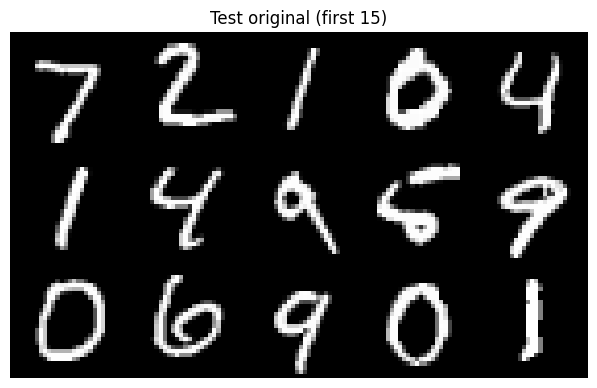

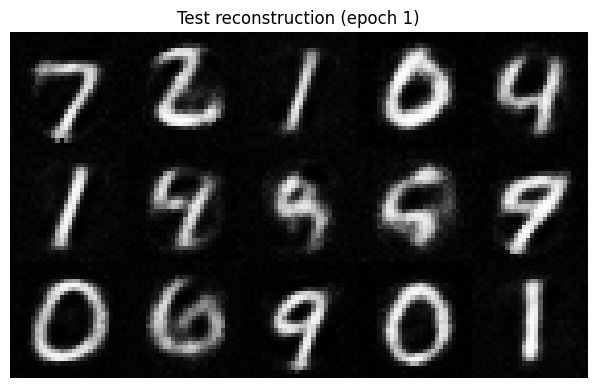

Epoch 02: train_loss=0.0169, val_loss=0.0137


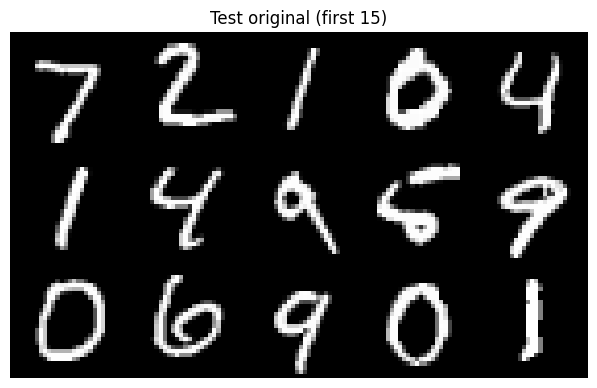

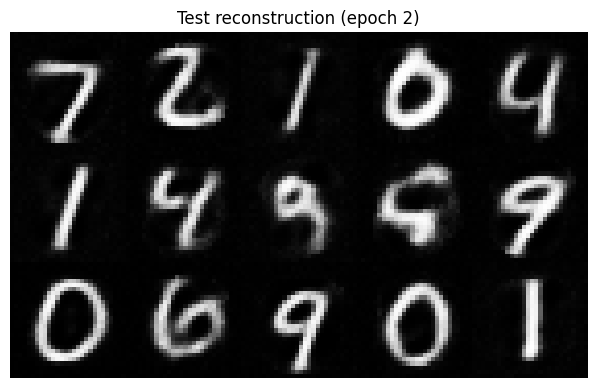

Epoch 04: train_loss=0.0104, val_loss=0.0096


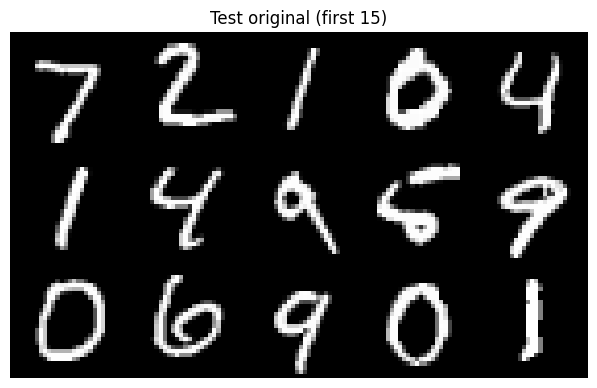

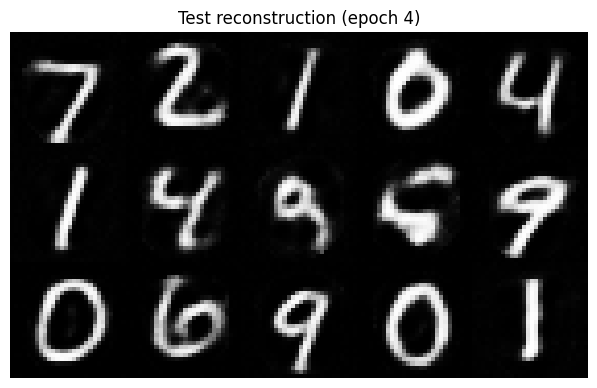

Epoch 06: train_loss=0.0084, val_loss=0.0080


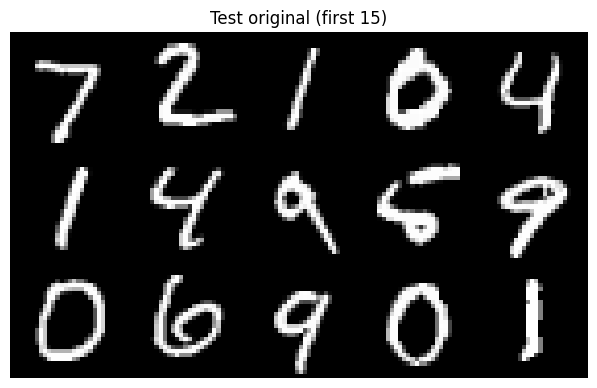

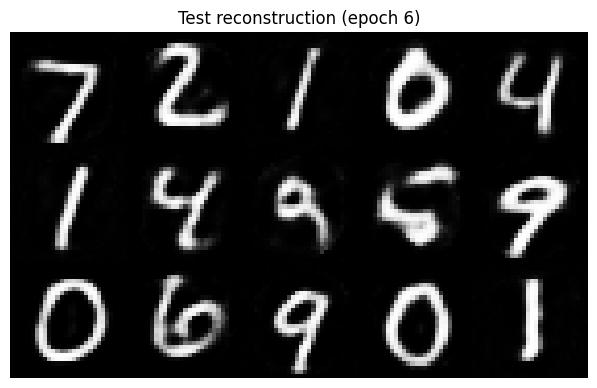

Epoch 08: train_loss=0.0073, val_loss=0.0070


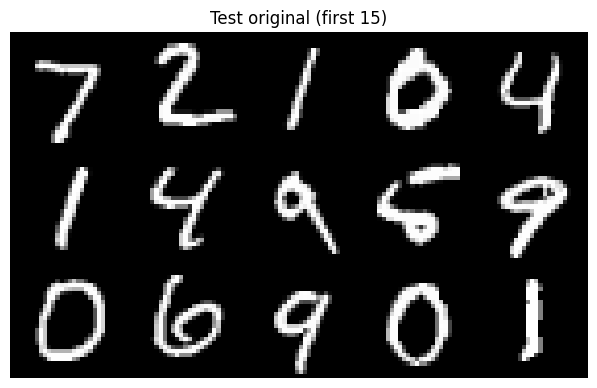

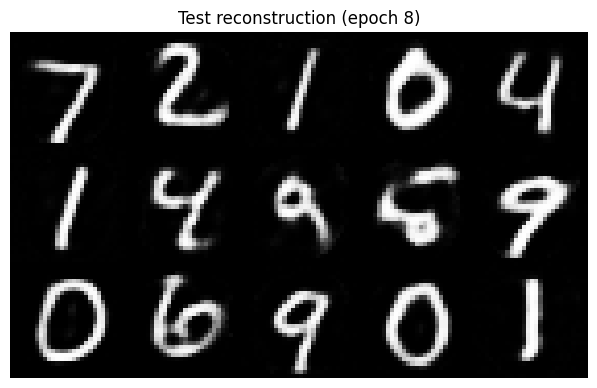

Epoch 10: train_loss=0.0066, val_loss=0.0066


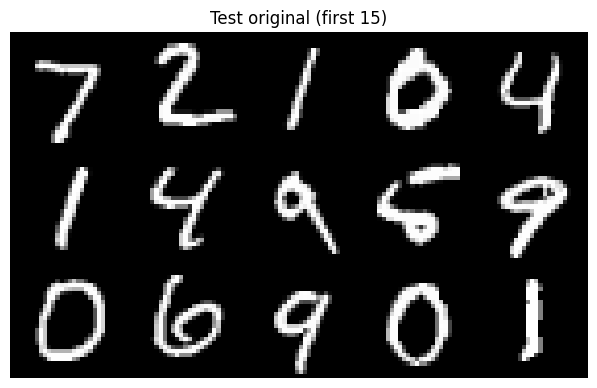

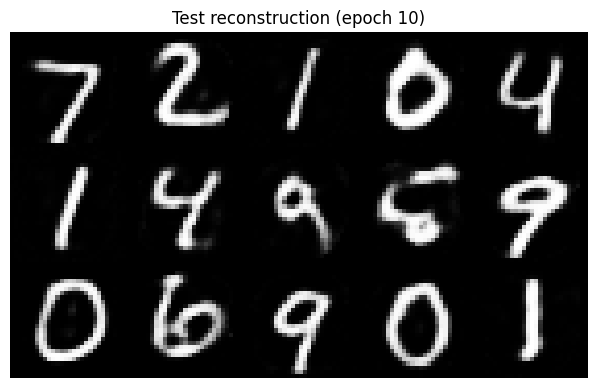

In [7]:
# -----------------------
# 4. 训练循环 Training Loop
# -----------------------
num_train = len(x_train)
num_val   = len(x_val)

for epoch in range(1, max_epoch+1):
    # 4.1 训练模式 Training mode
    encoder.train(); decoder.train()

    # 打乱索引，不改原数组 Shuffle indices without modifying the original array
    idx = np.random.permutation(num_train)
    epoch_losses = []

    st = 0
    while st < num_train:
        ed = min(st + batch_size, num_train)
        batch_idx = idx[st:ed]
        X = torch.from_numpy(x_train[batch_idx]).to(device)  # [B,784]

        # 前向：编码→解码 Forward: Encoding → Decoding
        Z     = encoder(X)        # [B,100]
        X_rec = decoder(Z)        # [B,784]

        # loss：MSE
        loss = loss_fn(X_rec, X)  # scalar

        # 反向：从标量出发，计算所有参数的梯度 Backward: Starting from a scalar, compute gradients for all parameters.
        optimizer.zero_grad()
        loss.backward()

        # 更新参数 update parameters
        optimizer.step()

        epoch_losses.append(loss.item())
        st = ed

    train_loss = float(np.mean(epoch_losses))

    # 4.2 验证模式（不计算梯度）Validation mode (no gradient computation)
    encoder.eval(); decoder.eval()
    with torch.inference_mode():
        val_losses = []
        st = 0
        while st < num_val:
            ed = min(st + batch_size, num_val)
            Xv = torch.from_numpy(x_val[st:ed]).to(device)
            Xv_rec = decoder(encoder(Xv))
            val_losses.append(loss_fn(Xv_rec, Xv).item())
            st = ed
        val_loss = float(np.mean(val_losses))

    if (epoch % display_step == 0) or (epoch == 1) or (epoch == max_epoch):
        print(f"Epoch {epoch:02d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
        # 可视化部分重建
        with torch.inference_mode():
            sample = torch.from_numpy(x_test[:15]).to(device)
            rec    = decoder(encoder(sample)).cpu().numpy()
        display(x_test[:15], 3, 5, title=f"Test original (first 15)")
        display(rec,        3, 5, title=f"Test reconstruction (epoch {epoch})")

In [8]:
# 5.计算test损失（放在训练结束、可视化之前）
encoder.eval()
decoder.eval()

test_losses = []
num_test = len(x_test)
st = 0
with torch.inference_mode():
    while st < num_test:
        ed = min(st + batch_size, num_test)
        Xt = torch.from_numpy(x_test[st:ed]).to(device)      # [B, 784]
        Xr = decoder(encoder(Xt))                             # [B, 784]
        loss = loss_fn(Xr, Xt).item()
        test_losses.append(loss)
        st = ed

test_loss = float(np.mean(test_losses))
print(f"Test loss: {test_loss:.4f}")

Test loss: 0.0064


Final reconstructions


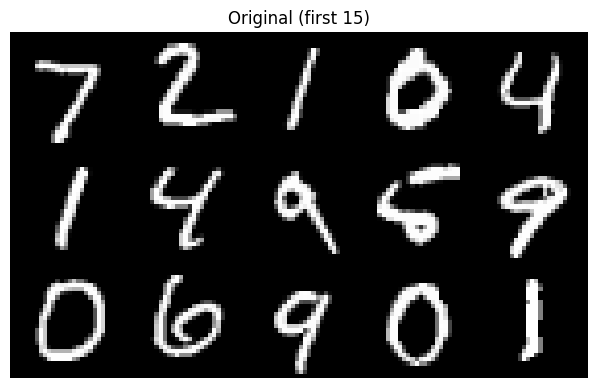

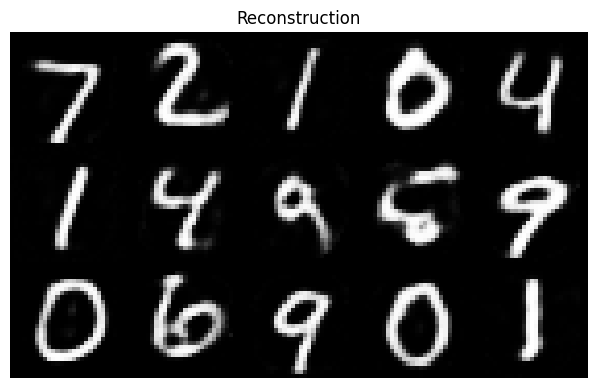

In [9]:
# -----------------------
# 6. 最终可视化
# -----------------------
print("Final reconstructions")
with torch.inference_mode():
    sample = torch.from_numpy(x_test[:15]).to(device)
    rec    = decoder(encoder(sample)).cpu().numpy()
display(x_test[:15], 3, 5, title="Original (first 15)")
display(rec,        3, 5, title="Reconstruction")

x_train = mnist_train.iloc[:, 1:].to_numpy().reshape(-1, 28 * 28) / 255说明：

mnist_train：一个 pandas DataFrame，存放 MNIST 训练集。通常第 0 列是标签（0–9），后面 784 列是像素。

.iloc[:, 1:]

使用整数位置索引取数据：: 取所有行，1: 从第 1 列取到最后一列。
作用：丢掉第 0 列的标签，只保留像素列（共 784 列）。
.to_numpy()

把选中的像素数据从 DataFrame 转成 NumPy 数组，方便后续数值计算。
.reshape(-1, 28 * 28)

把每张图展平成长度为 28*28=784 的向量。
-1 让 NumPy 自动推断样本数量（比如 60000），得到形状 (样本数, 784)。
/ 255

像素原本是 0–255 的整数，除以 255 把它们归一化到 [0, 1] 区间，利于模型训练

这是在mnist 的csv格式的数据集numpy化后，取其中的一部分numpy数组，进行图像可视化，但并不对其做任何编码解码操作，主要目的就是直观的让人知道在自动编码器前的数据集图像是如何的
做的事情：把 MNIST 的 CSV 数据集在“NumPy 化 + 归一化 + 展平”之后，从中取出一部分样本，用 reshape(28, 28) 还原为图像，并按网格拼接显示。
不做的事情：这一步完全不涉及编码器或解码器——没有任何“编码/解码/重建”操作。
主要目的：
直观检查数据：确认数据读取、归一化、展平是否正确；
建立视觉基准：了解原始输入长什么样，便于后续与“解码器重建图”做对比（定性评估模型表现）。

Q1：为什么要做压缩？
这样做的好处是，可以将高清图片（体积大）进行特征压缩，去除掉一些次要信息，保留主要特征，方便模型去学习，减轻模型学习的成本、降低模型学习的难度。
Q2：自动编码器到底是怎么解压的？
